<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/Final_project/Larissa_Santesso/entrega_01/ViT_T5_wandb_exp001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wandb

In [ ]:
!pip install wandb -qqq

     |████████████████████████████████| 1.8 MB 4.2 MB/s 
     |████████████████████████████████| 145 kB 75.2 MB/s 
     |████████████████████████████████| 181 kB 96.0 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


In [ ]:
# Log in to your W&B account
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
config_wandb={
        "learning_rate": 3e-4,
        "batch_size": 30,
        "architecture": "Vit + T5-small",
        "dataset": "MS-COCO 23k",
        "epochs": 50,
        "eval_epochs": 1,
        "encoder_pretrained_model": "google/vit-base-patch16-224-in21k",
        "decoder_pretrained_model": "google/t5-efficient-small-dm768",
        "path_save_model":  "/content/gdrive/MyDrive/Colab Notebooks/Projeto/modelos/model_ViT_T5_wandb_exp001.pt",
        "path_save_checkpoints":  "/content/gdrive/MyDrive/Colab Notebooks/Projeto/checkpoints/",
        "checkpoint_folder_name": "checkpoint.tar"

}


run = "001"

#run_id = '1jp17q6g'

# Bibliotecas


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.1 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 63.6 MB/s 
     |████████████████████████████████| 101 kB 13.5 MB/s 
     |████████████████████████████████| 596 kB 74.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 3.7 MB/s 


In [ ]:
from transformers import ViTFeatureExtractor, ViTModel, ViTConfig
from transformers import T5ForConditionalGeneration, T5Tokenizer

from matplotlib import pyplot as plt
import math
import random
import numpy as np
import h5py, json
from PIL import Image
import os
import time

import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader

import collections
import itertools
import functools
from tqdm.notebook import tqdm

from sacrebleu.metrics import BLEU

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

In [ ]:
# Check which GPU we are using
!nvidia-smi

Tue Jun 28 14:34:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


# Dataset: MS-COCO

## Download do dataset reduzido

In [ ]:
cd /media/larissa/SharedDisk/GoogleColab_content

/media/larissa/SharedDisk/GoogleColab_content


In [ ]:
ls

modelos/                                 VAL_CAPTIONS_coco_5_cap_per_img.json*
TEST_IMAGES_coco_5_cap_per_img.hdf5*     VAL_IMAGES_coco_5_cap_per_img.hdf5*
TRAIN_CAPTIONS_coco_5_cap_per_img.json*  wandb/
TRAIN_IMAGES_coco_5_cap_per_img.hdf5*


In [ ]:
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_IMAGES_coco_5_cap_per_img.hdf5
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_CAPTIONS_coco_5_cap_per_img.json
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5

--2022-06-29 23:15:51--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.187.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4624222304 (4.3G) [application/octet-stream]
Saving to: ‘TRAIN_IMAGES_coco_5_cap_per_img.hdf5’

TRAIN_IMAGES_coco_5 100%[===================>]   4.31G   259MB/s    in 18s     

2022-06-29 23:16:10 (243 MB/s) - ‘TRAIN_IMAGES_coco_5_cap_per_img.hdf5’ saved [4624222304/4624222304]

--2022-06-29 23:16:10--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... conne

In [ ]:
ls

gdrive/                                 TRAIN_IMAGES_coco_5_cap_per_img.hdf5
sample_data/                            VAL_CAPTIONS_coco_5_cap_per_img.json
TEST_IMAGES_coco_5_cap_per_img.hdf5     VAL_IMAGES_coco_5_cap_per_img.hdf5
TRAIN_CAPTIONS_coco_5_cap_per_img.json


## Construindo CocoDataset `class`


In [ ]:
class CocoDataset():
    def __init__(self, transform=None, mode_dataset = 'TRAIN'):
        
        self.transform = transform

        self.imgs = h5py.File(str(mode_dataset)+'_IMAGES_coco_5_cap_per_img.hdf5', 'r')
        self.imgs = self.imgs['images']
        self.captions = json.load(open(str(mode_dataset)+'_CAPTIONS_coco_5_cap_per_img.json'))

        assert len(self.imgs) == len(self.captions)

    def __len__(self):  
        return len(self.captions)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        caption = self.captions[idx]

        #if self.random_caption==True:
        #    caption = random.choice(caption) 
        
        if self.transform is not None:
            img = self.transform(np.transpose(np.copy(img), (1, 2, 0)))

        return img, caption

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained(config_wandb["encoder_pretrained_model"])

transform_train = transforms.Compose([
    transforms.ToTensor(),         
    transforms.RandomResizedCrop(feature_extractor.size),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)])

transform_val = transforms.Compose([
    transforms.ToTensor(),         
    transforms.Resize(feature_extractor.size),
    transforms.CenterCrop(feature_extractor.size),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)])


tokenizer = T5Tokenizer.from_pretrained(config_wandb["decoder_pretrained_model"])

train_dataset = CocoDataset(transform = transform_train)
val_dataset = CocoDataset(transform = transform_val, mode_dataset='VAL')
#test_dataset = CocoDataset(tokenizer = tokenizer, transform = transform_img, mode_dataset='TEST') ## não tem captions!!!



Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.94k [00:00<?, ?B/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Quantidade de amostras no dataset de treino: 23520
Quantidade de amostras no dataset de validação: 1052
--------------------
Saída da classe CocoDataset: 
Imagem = tensor([[[ 0.1529,  0.1571,  0.1608,  ...,  0.3506,  0.3565,  0.3647],
         [ 0.1610,  0.1651,  0.1671,  ...,  0.3562,  0.3626,  0.3687],
         [ 0.1701,  0.1742,  0.1753,  ...,  0.3600,  0.3677,  0.3725],
         ...,
         [-0.5419, -0.4747, -0.3904,  ..., -0.5919, -0.6128, -0.6075],
         [-0.4449, -0.3789, -0.2978,  ..., -0.5893, -0.5354, -0.4902],
         [-0.3647, -0.3071, -0.2354,  ..., -0.4576, -0.3592, -0.3098]],

        [[ 0.0431,  0.0431,  0.0448,  ...,  0.1435,  0.1451,  0.1451],
         [ 0.0512,  0.0533,  0.0543,  ...,  0.1386,  0.1411,  0.1411],
         [ 0.0588,  0.0629,  0.0640,  ...,  0.1311,  0.1350,  0.1358],
         ...,
         [-0.7008, -0.6635, -0.6141,  ..., -0.7112, -0.7314, -0.7290],
         [-0.6364, -0.5953, -0.5426,  ..., -0.6995, -0.6598, -0.6269],
         [-0.5843, -0.543

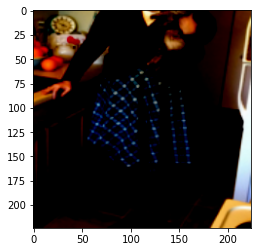

In [ ]:
print(f"Quantidade de amostras no dataset de treino: {len(train_dataset)}")
print(f"Quantidade de amostras no dataset de validação: {len(val_dataset)}")
print("-"*20)
x, y = train_dataset[0]
print(f"Saída da classe CocoDataset: ")
print(f"Imagem = {x} com tamanho de: {x.shape}")
plt.imshow(x.permute(1,2,0))

print("Legendas da imagem: ")
for i in y:
    print(i)

In [ ]:
def collate_custom(batch):
    imgs = [r[0] for r in batch]
    texts = [r[1] for r in batch] # all captions (5) of each image -- purpose: calculus of NLP metrics
    text = [random.choice(r[1]) for r in batch] # one random caption of each image -- purpose: for training
    

    #batch_tokens = tokenizer.batch_encode_plus(text, return_tensors="pt", max_length=32, padding='max_length', truncation=True, add_special_tokens=True)
    batch_tokens = tokenizer.batch_encode_plus(text, return_tensors="pt", padding="longest")

    return (
        torch.stack(imgs), 
        batch_tokens["input_ids"], 
        texts,
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


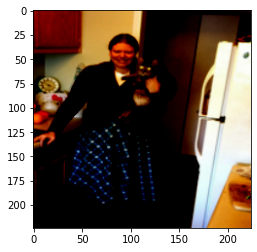

In [ ]:
train_loader_test = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn = collate_custom, drop_last=True)

x, y, z  = next(iter(train_loader_test))
plt.imshow(x.squeeze().permute(1,2,0))

In [ ]:
x.shape

torch.Size([1, 3, 224, 224])

In [ ]:
y

tensor([[   71,   885,   413,    13,     3,     9,  1001,    11,   872,  1712,
            28,    80,  1580,   539,     5,     1,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [    3,  8656,  4952,     3,  3484,  8128,    16,   851,    13,     3,
             9,   659,  1840,     5,     1,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [   71,   388,  3823,    30,     3,     9,  5726,  8453,    28,  1712,
            16,     8,    21,    15,  9232,     5,     1,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [   71,   568,     3,    89,  4664,     3,     9,  3650,    15,    30,
             3,     9,     3,  8343,   147,     3,     9,  6957,     5,     1,
             0,     0,     0,     0,     0,     0,     0,  

In [ ]:
x

tensor([[[[ 2.7451e-02, -3.7367e-01, -4.2234e-01,  ...,  4.3792e-01,
            4.4156e-01,  4.3529e-01],
          [ 2.4963e-01, -1.0830e-01, -3.5382e-01,  ...,  4.3591e-01,
            4.3556e-01,  4.2929e-01],
          [ 4.1324e-01,  7.2342e-02, -2.9924e-01,  ...,  4.4007e-01,
            4.3946e-01,  4.3701e-01],
          ...,
          [ 2.2463e-01,  2.0230e-01,  1.7289e-01,  ...,  1.1876e-01,
            1.3705e-01,  1.9914e-01],
          [ 1.3456e-01,  1.1458e-01,  8.5267e-02,  ..., -1.8549e-01,
           -1.4234e-01, -6.1152e-02],
          [ 7.4510e-02,  1.1211e-01,  1.3722e-01,  ..., -4.4576e-01,
           -4.4625e-01, -4.2745e-01]],

         [[ 3.3333e-01, -9.9125e-02, -1.6611e-01,  ...,  6.8887e-01,
            6.8001e-01,  6.8627e-01],
          [ 5.3750e-01,  1.4823e-01, -9.9624e-02,  ...,  6.9688e-01,
            6.9202e-01,  6.9828e-01],
          [ 6.8125e-01,  3.9686e-01,  2.1309e-02,  ...,  6.9616e-01,
            6.9281e-01,  6.8762e-01],
          ...,
     

In [ ]:
y['input_ids']

tensor([[   46,  1023,    13,   388,    28,     3,     9, 17351,    16,     3,
             9,  6177,     1,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [   71,  1001,    11,   872,  1712,     3, 14720,    30,     3,     9,
          4544,  7827,  8680,    28,     8,  1641,    30,     5,     1,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [    3,  8656,   151,  1556,     3,  3233,    32,    30,  4952,   223,
            38,     3,     9,  2335, 10681,    57,     1,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [   71,  1131,    11,     3,    17,   152,  9321,  4125,    16,   306,
          5956,   365,   633,  3124,     5,     1,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,  

In [ ]:
y['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
z

[['The fire truck is participating in the annual parade.',
  'A red truck with two America flags on the front.',
  'A red truck driving past a tall yellow house.',
  'red truck sitting in the middle of the road.',
  'A red truck that says, "Forest Fire Service" on the side in yellow and green. '],
 ['there is a small black cat playing with a yellow umbrella',
  'A black cat playing with the frame of a yellow umbrella.',
  'A small black cat reaching up to the inside of a yellow umbrella with both paws.',
  'The black cat is standing on the handle of a yellow umbrella.',
  'A black cat that is trying to close up an umbrella. '],
 ['the woman is holding on to the horse by a leash',
  'At the picture is a scene of an outside town.\n',
  'The rider is taking her horse to the barn.',
  'A woman is loading horses on to a trailer.',
  'A brown horse standing next to a woman and a trailer.'],
 ['A white car is parked in front of a parking meter.',
  'A parking meter next to a car on the road.'

## Função para desnormalizar a imagem

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

# Modelo: Encoder (ViT) e Decoder (T5)

In [ ]:
class MyEncoder(nn.Module):
    def __init__(self, pretrained_model):
        """
        Implements the Encoder."

        Args:
            pretrained_model (str): name of the pretrained model

        """

        super(MyEncoder, self).__init__()

        self.encoder = ViTModel.from_pretrained(pretrained_model)

    def forward(self, input):
        # Com camada MLP do ViT
        out  = self.encoder(pixel_values = input)

        return out

In [ ]:
class MyDecoder(nn.Module):
    def __init__(self, pretrained_model):
        """
        Implements the Encoder."

        Args:
            pretrained_model (str): name of the pretrained model

        """
        
        super(MyDecoder, self).__init__()

        self.decoder = T5ForConditionalGeneration.from_pretrained(pretrained_model)

    def forward(self, output_encoder, targets, decoder_ids=None):
        # Validation/Testing
        if decoder_ids is not None:
            out = self.decoder(encoder_outputs=output_encoder, decoder_input_ids=decoder_ids)

        # Training
        else:
            out = self.decoder(encoder_outputs=output_encoder, labels=targets)

        return out

In [ ]:
from typing import Tuple

class EncoderDecoder(nn.Module):
    def __init__(self, pretrained_model: Tuple[str], eos_token_id=None, pad_token_id=None):
        """
        Implements the Encoder."

        Args:
            pretrained_model (tuple): name of the pretrained model
            eos_token_id (torch.long): token used for end of sentence  
            pad_token_id (torch.long): token used for padding

        """
        
        super(EncoderDecoder, self).__init__()
        self.eos_token_id = eos_token_id
        self.pad_token_id = pad_token_id
        self.encoder = MyEncoder(pretrained_model[0])

        # Freeze parameters from encoder
        #for p in self.encoder.parameters():
        #    p.requires_grad=False
            
        self.decoder = MyDecoder(pretrained_model[1])
        self.decoder_start_token_id = self.decoder.decoder.config.decoder_start_token_id

    def forward(self, images = None, targets = None, decoder_ids = None):
        output_encoder  = self.encoder(images)
        out = self.decoder(output_encoder, targets, decoder_ids)

        return out

In [ ]:
model = EncoderDecoder(pretrained_model = (config_wandb["encoder_pretrained_model"], config_wandb["decoder_pretrained_model"]), 
                       eos_token_id=tokenizer.eos_token_id, 
                       pad_token_id=tokenizer.pad_token_id)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/635 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Número de parâmetros do modelo: {num_params}')

Número de parâmetros do modelo: 177148928


# Treinamento

  0%|          | 0/470 [00:00<?, ?it/s]

3.0206853506412914


  0%|          | 0/21 [00:00<?, ?it/s]

['A woman holding a hot dog in a field.', 'A street sign with a street sign on it.', 'A large truck parked on a green field.', 'A cat is sitting on a toilet in a bathroom.', 'A man riding a motorcycle on a street.', 'A large airplane is parked on the runway.', 'A large airplane is parked on the runway.', 'A man riding a motorcycle on a street.', 'A large jet flying through the air.', 'A small bird perched on top of a tree branch.', 'A bird perched on a branch in a tree.', 'A cat laying on top of a truck.', 'A small boat parked on a lake next to a tree.', 'A cat laying on a bed with a cat on it.', 'A cat laying on top of a bed with a white cat.', 'A cat sitting on top of a wooden bench.', 'A cat laying on a bed with a laptop.', 'A cat sitting on a couch next to a couch.', 'A truck is parked in front of a building.', 'A horse standing next to a tree.', 'A cat laying on top of a laptop computer.', 'A man standing next to a tree in a field.', 'A elephant standing in a tree in a forest.', '

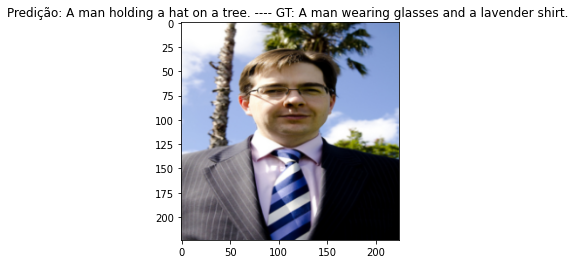

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Época: 0/49 Train Loss: 3.020685 / Train BLEU: 3.7829225133028728 Valid BLEU: 19.644427758546396


  0%|          | 0/470 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
# Treinamento

model = EncoderDecoder(pretrained_model = (config_wandb["encoder_pretrained_model"], config_wandb["decoder_pretrained_model"]), 
                       eos_token_id=tokenizer.eos_token_id, 
                       pad_token_id=tokenizer.pad_token_id)

model = model.to(device)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=config_wandb["batch_size"], shuffle=True, collate_fn = collate_custom, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=config_wandb["batch_size"], collate_fn = collate_custom, drop_last=True)

# Optmizer
optimizer = torch.optim.Adam(model.parameters(), lr=config_wandb["learning_rate"])

# referencia: https://towardsdatascience.com/machine-translation-evaluation-with-sacrebleu-and-bertscore-d7fdb0c47eb3
bleu = BLEU()

# Initializing Lists
train_losses = []
val_losses = []
val_bleu_epoch = []
train_bleu_epoch = []


# Starting wandb
if run_id is not None:
    print(run_id)
    run = wandb.init(project="Image_Captioning", name=f"experiment_{run}", config=config_wandb, resume=run_id, id=run_id, settings=wandb.Settings(start_method="thread"), reinit=True, dir=os.getenv("WANDB_DIR", config_wandb["path_save_checkpoints"]))

else:
    epoch_init = 0
    run = wandb.init(project="Image_Captioning", name=f"experiment_{run}", config=config_wandb, resume=True, settings=wandb.Settings(start_method="thread"), reinit=True, dir=os.getenv("WANDB_DIR", config_wandb["path_save_checkpoints"]))

# 3. Log gradients and model parameters - pode ter dado erro, cuidado! 
#wandb.watch(model)

if wandb.run.resumed:
    print("Wandb --resumed")
    wandb.restore(config_wandb["path_save_checkpoints"]+config_wandb["checkpoint_folder_name"])
    epoch_init = wandb.run.step
    print(epoch_init)
    checkpoint = torch.load(config_wandb["path_save_checkpoints"]+config_wandb["checkpoint_folder_name"])
    print(checkpoint['loss'])
    print(checkpoint['epoch'])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #epoch_init = checkpoint['epoch']+1
    loss = checkpoint['loss']

for epoch in range(epoch_init, config_wandb["epochs"]):
    bleu_list = []
    for batch, (train_inputs, train_targets, train_all_targets) in enumerate(tqdm(train_loader)):
        model.train()
        model.zero_grad()

        train_inputs = train_inputs.to(device)
        train_targets = train_targets.to(device)

        # para o calculo da loss deve aplicar a máscara no start of sequence também? 
        mylabels = train_targets.clone()
        mylabels[mylabels==tokenizer.pad_token_id] = -100

        train_output = model(images = train_inputs, targets=mylabels)
        logits = train_output.logits
        loss = train_output.loss
        
        train_preds = torch.argmax(logits, dim=-1)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        preds_sentences = tokenizer.batch_decode(train_preds,  skip_special_tokens=True) #returns a list
        bleu_result = bleu.corpus_score(preds_sentences, list(zip(*train_all_targets)))
        bleu_list.append(bleu_result.score)

        wandb.log({"train/batch": batch,
                   "train/batch/loss":loss.item(), 
                   "train/batch/bleu_score":bleu_result.score, 
                   "train/batch/bleu_score_p1":bleu_result.precisions[0],
                   "train/batch/bleu_score_p4":bleu_result.precisions[3]})
        
    train_loss = sum(train_losses)/len(train_losses)
    print(train_loss)
    train_bleu = sum(bleu_list)/len(bleu_list)
    train_bleu_epoch.append(train_bleu)
    torch.save(model, config_wandb["path_save_model"])
    

    with torch.no_grad():
        bleu_list = []
        for val_batch, (val_inputs, val_targets, val_all_targets) in enumerate(tqdm(val_loader)):
            val_inputs = val_inputs.to(device)

            model.eval()
    
            decoded_ids = torch.full((val_inputs.shape[0], 1),
                            model.decoder_start_token_id,
                            dtype=torch.long).to(val_inputs.device)
            
            for step in range(32):
                output_val =  model(images =  val_inputs, decoder_ids= decoded_ids)
                
                #print(f"logits.shape: {output_val.logits.shape}")
                val_logits = output_val.logits
                next_token_logits = val_logits[:, -1, :]
                next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
                decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)
                #print(f"decoded_ids batch: {decoded_ids}")

                # Check if output is end of senquence for all batches
                if torch.eq(next_token_id[:, -1], model.eos_token_id).all():
                    break



            val_preds_sentences = tokenizer.batch_decode(decoded_ids,  skip_special_tokens=True)
            print(val_preds_sentences)
            bleu_result = bleu.corpus_score(val_preds_sentences, list(zip(*val_all_targets)))
            bleu_list.append(bleu_result.score)

            wandb.log({"val/batch": val_batch, 
                    "val/batch/loss":loss.item(),
                   #"val/batch/preds_sentences": val_preds_sentences, 
                   "val/batch/bleu_score":bleu_result.score, 
                   "val/batch/bleu_score_p1":bleu_result.precisions[0],
                   "val/batch/bleu_score_p4":bleu_result.precisions[3]})
            #my_table = wandb.Table(columns=["Image", "captions_generated"], data=[val_inputs,val_preds_sentences])
            #run.log({"val/table": my_table}, step=epoch)
        val_bleu = sum(bleu_list)/len(bleu_list)
        val_bleu_epoch.append(val_bleu)
            
    
    if epoch % config_wandb["eval_epochs"] == 0:
        plt.figure()
        plt.imshow(unorm(val_inputs[0].cpu()).permute(1,2,0))
        plt.title("Predição: "+str(val_preds_sentences[0] + " ---- GT: " +str(val_all_targets[0][0])))
        plt.show()
        plt.pause(0.05)

    wandb.log({"epoch": epoch, 
                "train/epoch/loss": train_loss,
                "train/epoch/bleu_score": train_bleu, 
                "val/epoch/bleu_score": val_bleu})

    torch.save({ # Save our checkpoint loc
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        }, config_wandb["path_save_checkpoints"]+config_wandb["checkpoint_folder_name"])
    wandb.save() # saves checkpoint to wandb
         
    print(f'Época: {epoch:d}/{config_wandb["epochs"] - 1:d} Train Loss: {train_loss:.6f} / Train BLEU: {train_bleu} Valid BLEU: {val_bleu}')

run_id: 1jp17q6g


Wandb --resumed
539
tensor(2.8179, device='cuda:0', requires_grad=True)
0


  0%|          | 0/784 [00:00<?, ?it/s]

2.5160797116707783


  0%|          | 0/35 [00:00<?, ?it/s]

['A woman holding a dog and a dog.', 'A man is walking down a street with a car.', 'A blue and white truck with a blue and white car.', 'A cat is sitting on top of a sink.', 'A man is riding a motorcycle on a street.', 'A large airplane is parked on the runway.', 'A large airplane sitting on top of a runway.', 'A man is standing in front of a car.', 'A large jetliner flying through the sky.', 'A bird is standing on a tree branch.', 'A bird is standing on a tree branch.', 'A cat sitting on top of a blue suitcase.', 'A boat is parked in the grass near a tree.', 'A cat is sitting on a couch with a blanket.', 'A cat is sitting on a chair with a stuffed animal.', 'A cat sitting on top of a wooden bench.', 'A cat is sitting on a couch with a laptop.', 'A cat sitting on top of a couch with a laptop.', 'A truck is parked on the side of the road.', 'A horse standing in a field with a cow in the background.', 'A cat sitting on top of a laptop computer.', 'A man in a hat is standing in the grass.

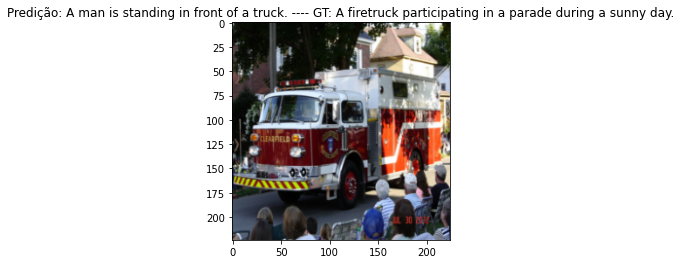

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Época: 1/49 Train Loss: 2.516080 / Train BLEU: 6.245428502454508 Valid BLEU: 20.09901303401105


  0%|          | 0/784 [00:00<?, ?it/s]

2.4407298648539855


  0%|          | 0/35 [00:00<?, ?it/s]

['A woman sitting on a bench with a dog.', 'A parking meter with a car in the background.', 'A blue and blue truck parked in a field.', 'A cat sitting on a toilet seat in a bathroom.', 'A man riding a motorcycle in front of a house.', 'A small plane is parked in the dirt.', 'A small plane sitting on a runway.', 'A car is parked in front of a car.', 'A small airplane flying in the air.', 'A bird sitting on a branch in a tree.', 'A small bird sitting on a branch.', 'A cat sitting on a blue chair in a car.', 'A red truck is parked in a field.', 'A dog sitting on a couch with a dog.', 'A cat laying on a couch with a stuffed animal.', 'A cat is sitting on a wooden bench.', 'A cat sitting on a couch with a cat in it.', 'A dog sitting on a couch with a couch.', 'A bus is parked in front of a building.', 'A cow standing next to a cow in a field.', 'A cat sitting on a desk next to a remote.', 'A giraffe standing in a field with a tree in the background.', 'A large elephant standing next to a tr

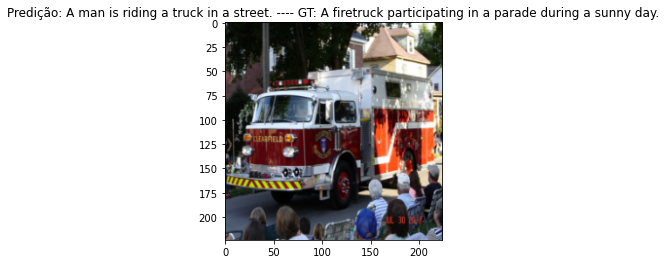

Época: 2/49 Train Loss: 2.440730 / Train BLEU: 7.088273619198594 Valid BLEU: 21.533634748884605


  0%|          | 0/784 [00:00<?, ?it/s]

2.3875454579080855


  0%|          | 0/35 [00:00<?, ?it/s]

['A woman is holding a stuffed animal on a bench.', 'A man is standing on a bench next to a car.', 'A man is standing next to a truck with a dog.', 'A black and white cat sitting on a toilet seat.', 'A man is riding a motorcycle down a street.', 'A small airplane is parked on the ground.', 'A large jetliner sitting on top of an airport tarmac.', 'A man is standing next to a car on a street.', 'A small plane is flying in the sky.', 'A bird perched on a branch of a tree branch.', 'A zebra is sitting on a tree branch.', 'A cat sitting on a bench next to a computer.', 'A boat is parked in the grass near a tree.', 'A cat laying on a couch with a cat on it.', 'A cat laying on a bed with a blanket. on a bed with a blanket.', 'A cat sitting on a table with a stuffed animal.', 'A cat laying on a bed with a laptop. on a blue suitcase.', 'A cat sitting on a couch with a laptop on it.', 'A truck is parked in a parking lot with a lot of people.', 'A cow is standing in the grass near a mountain.', '

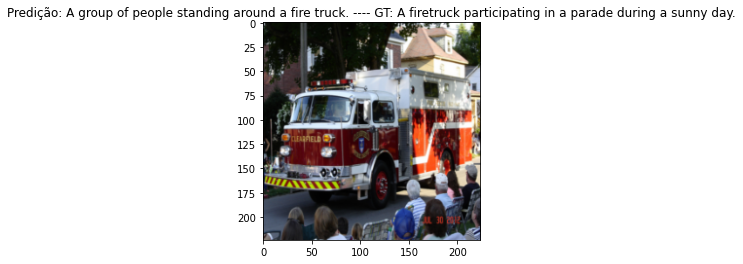

Época: 3/49 Train Loss: 2.387545 / Train BLEU: 7.748939544169291 Valid BLEU: 21.317264387500828


  0%|          | 0/784 [00:00<?, ?it/s]

2.35100720773394


  0%|          | 0/35 [00:00<?, ?it/s]

['A woman sitting on a bench with a dog.', 'A man riding a horse on a street.', 'A blue truck parked in a field.', 'A black cat sitting on top of a toilet.', 'A man riding a motorcycle on a city street.', 'A small airplane is parked on the runway.', 'A large jetliner sitting on top of an airport tarmac.', 'A car parked on a street next to a building.', 'A small white airplane flying through a blue sky.', 'A bird perched on a branch in a tree.', 'A tan bear standing on a tree branch.', 'A cat sitting on top of a blue suitcase.', 'A red and white truck parked in a grassy area.', 'A cat laying on a couch next to a cat.', 'A cat laying on top of a white blanket.', 'A cat sitting on a rock next to a tree.', 'A cat laying on top of a black suitcase.', 'A black cat sitting on top of a chair.', 'A white bus driving down a street.', 'A cow standing next to a tree in a field.', 'A black cat sitting on a chair next to a pair of shoes.', 'A herd of sheep standing in a field.', 'A elephant standing

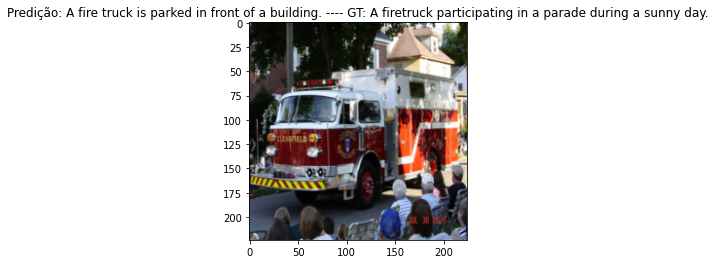

Época: 4/49 Train Loss: 2.351007 / Train BLEU: 8.019977209674147 Valid BLEU: 23.448792985492858


  0%|          | 0/784 [00:00<?, ?it/s]

2.317377232349649


  0%|          | 0/35 [00:00<?, ?it/s]

['A woman holding a hot dog with a ketchup and mustard.', 'A car is driving down the street with a car and a car.', 'A blue truck with a blue and white car in the back.', 'A cat is sitting in a toilet seat in a bathroom.', 'A man riding a motorcycle on a city street.', 'A small airplane is sitting on the ground.', 'A large airplane sitting on top of a runway.', 'A man standing next to a car on a street.', 'A small airplane flying through a blue sky.', 'A bird perched on a branch in a tree.', 'A bird perched on a tree branch in a tree.', 'A cat sitting on top of a blue truck.', 'A small dog sitting on top of a red truck.', 'A cat is laying on a couch with a remote control.', 'A cat laying on a bed with a blanket.', 'A cat is sitting on a tree branch.', 'A cat is laying on top of a suitcase.', 'A cat is sitting on a chair with a cat on it.', 'A white and blue bus is parked in front of a parking lot.', 'A group of sheep standing in a field with a dog.', 'A cat is sitting on a couch next t

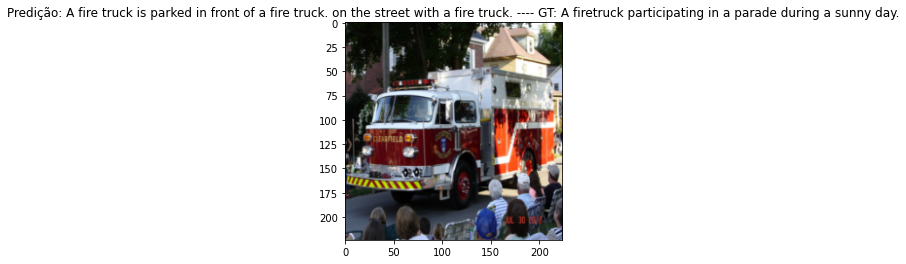

Época: 5/49 Train Loss: 2.317377 / Train BLEU: 8.390457406630658 Valid BLEU: 21.53551187802291


  0%|          | 0/784 [00:00<?, ?it/s]

2.290035054594481


  0%|          | 0/35 [00:00<?, ?it/s]

['A young boy holding a small bird on a bench.', 'A car is parked next to a parking meter.', 'A blue truck parked in a field with a lot of people in the background.', 'A cat is sitting in a toilet bowl.', 'A man riding a motorcycle on a city street.', 'A small plane is parked on the runway.', 'A large jetliner sitting on top of an airport tarmac.', 'A car is parked in the middle of a city.', 'A small airplane flying through the sky.', 'A small bird perched on a branch in a tree.', 'A bird is perched on a tree branch.', 'A cat sitting on top of a blue suitcase.', 'A red and white boat parked next to a lake.', 'A dog laying on a couch with a cat on it.', 'A cat laying on a chair with a stuffed animal.', 'A cat is sitting on a bench with a stuffed animal.', 'A cat laying on top of a suitcase.', 'A cat laying on a couch in a living room.', 'A white and black train traveling down a city street.', 'A cow standing in the grass next to a tree.', 'A cat is sitting in a cage with a remote contro

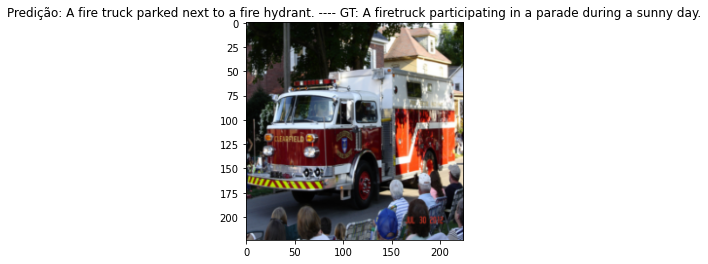

Época: 6/49 Train Loss: 2.290035 / Train BLEU: 8.542003241180057 Valid BLEU: 23.34856600287434


  0%|          | 0/784 [00:00<?, ?it/s]

2.2650570408943445


  0%|          | 0/35 [00:00<?, ?it/s]

['A woman holding a cat with a cat.', 'A street sign with a street sign on it.', 'A blue and white truck with a surfboard on top.', 'A black cat is sitting on a toilet bowl.', 'A man riding a motorcycle next to a red car.', 'A man on a skateboard is boarding a plane.', 'A plane is parked at the airport.', 'A car parked on the side of the road.', 'A small plane flying through a blue sky.', 'A small bird perched on a branch of a tree.', 'A bird sitting on a tree branch in a tree.', 'A cat sitting on top of a suitcase on a desk.', 'A dog sitting on top of a red boat.', 'A dog is laying on a leather chair.', 'A cat sitting on a chair with a stuffed animal.', 'A cat sitting on top of a wooden bench.', 'A cat is laying on a suitcase.', 'A black cat sitting on top of a laptop computer.', 'A white truck with a white hood and a white car on the side.', 'A cow standing in the grass with a cow in the background.', 'A cat sitting on a bed next to a remote control.', 'A group of giraffes standing i

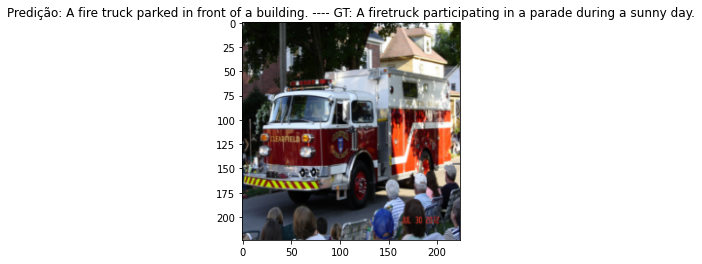

Época: 7/49 Train Loss: 2.265057 / Train BLEU: 8.868814585281275 Valid BLEU: 24.2647917301328


  0%|          | 0/784 [00:00<?, ?it/s]

2.242280176593637


  0%|          | 0/35 [00:00<?, ?it/s]

['A woman holding a dog with a dog in her lap.', 'A woman walking down a street with a dog.', 'A blue truck parked in a field with a tree in the background.', 'A cat sitting on top of a toilet seat.', 'A man riding a motorcycle with a dog on it.', 'A small airplane is parked on the side of the road.', 'A large white and blue airplane sitting on a runway.', 'A car is parked in front of a building.', 'A small airplane flying through the air with a propeller.', 'A bird sitting on a branch with a tree in the background.', 'A bird sitting on top of a tree branch.', 'A cat sitting on top of a blue car.', 'A red and white boat with a dog sitting on top of it.', 'A dog laying on a couch with a blanket.', 'A cat laying on top of a stuffed animal.', 'A cat laying on top of a tree branch.', 'A cat laying in a suitcase with a cat in it.', 'A cat sitting on top of a chair in a room.', 'A white car parked in front of a building.', 'A cow and a cow standing in a field.', 'A cat sitting on a rug with 

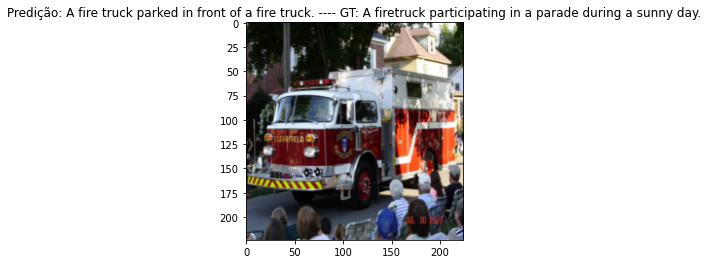

Época: 8/49 Train Loss: 2.242280 / Train BLEU: 9.206433929857276 Valid BLEU: 23.92094713825969


  0%|          | 0/784 [00:00<?, ?it/s]

2.2230018027076106


  0%|          | 0/35 [00:00<?, ?it/s]

['A woman holding a dog in her lap.', 'A woman walking down a street next to a car.', 'A blue truck with a blue car in the back.', 'A black cat sitting on a toilet seat.', 'A man riding a motorcycle with a dog.', 'A small airplane is sitting on the runway.', 'A large jetliner sitting on top of an airport tarmac.', 'A white car is parked on the side of the street.', 'A small airplane flying in the sky.', 'A red and black bird perched on a branch.', 'A teddy bear sitting on a tree branch.', 'A cat sitting on top of a suitcase.', 'A boat with a dog sitting on top of it.', 'A dog laying on a bed with a cat.', 'A cat laying on a bed next to a stuffed animal.', 'A cat laying on a wooden bench next to a tree.', 'A cat is sitting in a suitcase with a cat.', 'A black cat sitting on a chair in front of a window.', 'A truck with a lot of people in it.', 'A group of cows standing in the grass near a mountain.', 'A black cat sitting next to a laptop computer.', 'A giraffe standing in a field next t

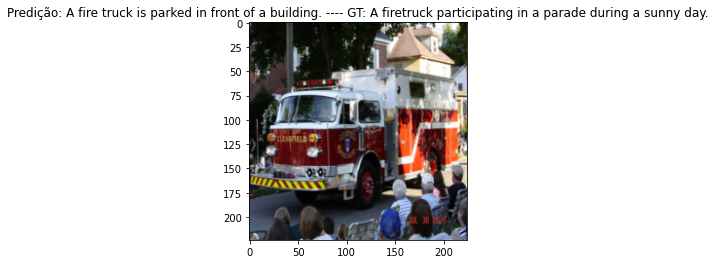

Época: 9/49 Train Loss: 2.223002 / Train BLEU: 9.384860174652323 Valid BLEU: 24.46291920663726


  0%|          | 0/784 [00:00<?, ?it/s]

2.205294880453421


  0%|          | 0/35 [00:00<?, ?it/s]

['A young boy holding a dog in his hand. him.', 'A man is walking down a street with a dog.', 'A blue truck with a blue hood is parked in a field.', 'A black cat sitting on top of a toilet seat.', 'A man riding a motorcycle with a dog on it.', 'A small airplane sitting on top of a runway.', 'A large jetliner sitting on top of an airport tarmac.', 'A car parked next to a parking meter.', 'A small airplane flying in the sky.', 'A bird sitting on a branch of a tree.', 'A bird sitting on a tree branch in a forest.', 'A cat sitting on top of a wooden desk.', 'A man and a dog are sitting in a boat.', 'A dog laying on a couch with a couch in the background.', 'A cat sitting on a chair with a stuffed animal.', 'A cat laying on a wooden bench.', 'A cat laying in a suitcase on a table.', 'A cat sitting on a chair in front of a chair.', 'A white and blue truck parked on the side of a street.', 'A dog and a dog standing in a field.', 'A cat sitting on a couch next to a remote control.', 'A giraffe

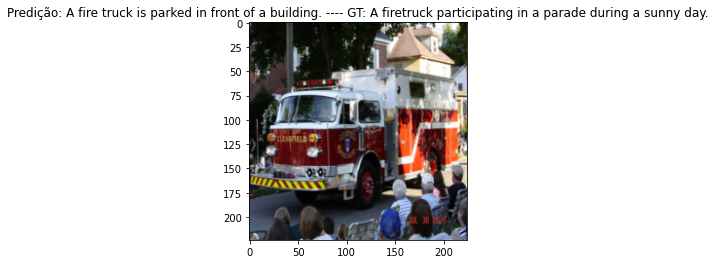

Época: 10/49 Train Loss: 2.205295 / Train BLEU: 9.762500177916435 Valid BLEU: 23.930459951117808


  0%|          | 0/784 [00:00<?, ?it/s]

2.188036668237043


  0%|          | 0/35 [00:00<?, ?it/s]

['A woman holding a cat on a bench.', 'A car is parked on the side of a street.', 'A vintage car parked on the grass near a tree.', 'A cat sitting on top of a toilet seat.', 'A man riding a motorcycle with a dog on the back.', 'A small plane is parked on the runway.', 'A large jetliner sitting on top of an airport tarmac.', 'A man standing next to a car on a street.', 'A small plane flying through a cloudless sky.', 'A bird sitting on a branch in a tree.', 'A large bird sitting on top of a tree branch.', 'A cat sitting on top of a blue suitcase.', 'A man standing on a red boat in the water.', 'A dog laying on a couch with a cat sleeping on it.', 'A cat laying on a bed with a stuffed animal.', 'A cat laying on a wooden bench next to a stuffed animal.', 'A cat laying in a suitcase on a bed.', 'A cat sitting on top of a green chair.', 'A white truck with a white hood and a white car on the side of it.', 'A brown and white horse standing on top of a grass covered field.', 'A cat is sitting

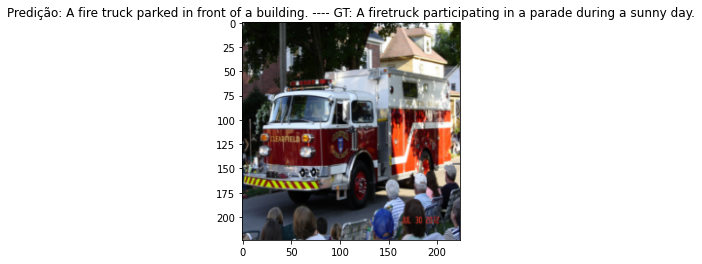

Época: 11/49 Train Loss: 2.188037 / Train BLEU: 9.779679597330459 Valid BLEU: 23.439289280247767


  0%|          | 0/784 [00:00<?, ?it/s]

2.1717137490608254


  0%|          | 0/35 [00:00<?, ?it/s]

['A woman holding a small dog in her hands.', 'A dog is walking on a sidewalk near a parking meter.', 'A blue and blue boat parked on a green field.', 'A cat is drinking water from a toilet.', 'A man sitting on a motorcycle with a dog on it.', 'A small airplane is sitting on the runway.', 'A plane is parked at the airport with a person.', 'A man standing next to a car on a street.', 'A small airplane flying through a cloudy sky.', 'A couple of birds sitting on a branch in a tree.', 'A bird sitting on a branch in a tree.', 'A cat sitting on a blue bench in front of a blue door.', 'A red and white boat parked in a grassy area.', 'A dog laying on a couch with a cat laying on it.', 'A cat laying on a bed with a stuffed animal.', 'A cat laying on a wooden bench in front of a tree.', 'A cat laying on a bed with a remote control.', 'A cat sitting on a chair on a chair.', 'A white and blue train car with people on it.', 'A brown and white cow standing on a dirt road.', 'A cat is sitting on a c

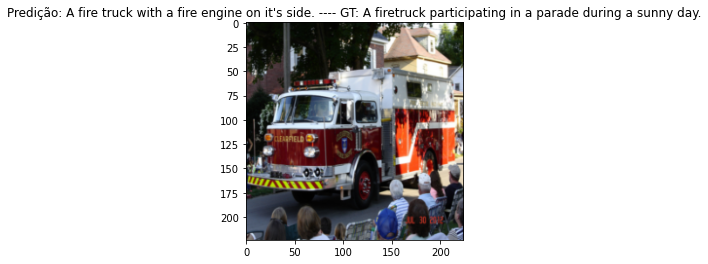

Época: 12/49 Train Loss: 2.171714 / Train BLEU: 9.93053781484545 Valid BLEU: 25.24163905837385


  0%|          | 0/784 [00:00<?, ?it/s]

2.156814949993436


  0%|          | 0/35 [00:00<?, ?it/s]

['A woman holding a dog in her arms.', 'A man is riding a horse drawn carriage down a street.', 'A blue truck with a blue hood is parked in a grassy field.', 'A cat sitting on top of a toilet seat.', 'A man riding a motorcycle with a dog on the back.', 'A small plane sitting on top of a runway.', 'A large jetliner sitting on top of an airport tarmac.', 'A man is standing next to a car on a street.', 'A small plane flying through a cloudy sky.', 'A bird perched on a branch in a tree.', 'A bird perched on a branch in a tree.', 'A cat sitting on top of a suitcase.', 'A dog sitting on top of a red boat.', 'A dog and cat laying on a bed.', 'A cat laying on a blanket on a bed.', 'A cat and a cat are sitting on a stone wall.', 'A cat laying in a suitcase on a bed.', 'A black cat sitting on top of a couch.', 'A white truck with a white rim on the side of it.', 'A brown and white cow standing on a dirt road.', 'A cat sitting next to a remote control.', 'A man is holding a dog in a field.', 'An 

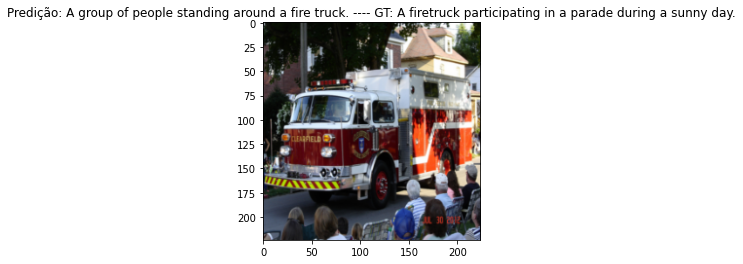

Época: 13/49 Train Loss: 2.156815 / Train BLEU: 10.07157112755749 Valid BLEU: 25.301134723668195


  0%|          | 0/784 [00:00<?, ?it/s]

2.1421335650276685


  0%|          | 0/35 [00:00<?, ?it/s]

['A woman holding a cat in her lap.', 'A group of people walking down a street.', 'A blue and white truck parked in a field.', 'A cat is drinking out of a toilet.', 'A man riding a motorcycle with a dog on it.', 'A small airplane is sitting on a runway.', 'A plane is parked at an airport terminal.', 'A man walking down a street next to a car.', 'A small plane flying in the sky.', 'A bird is sitting on a branch of a tree.', 'A bird sitting on a branch in a tree.', 'A cat sitting on top of a blue suitcase.', 'A red and white train car with a dog on it.', 'A dog laying on top of a red couch.', 'A cat laying on a couch next to a pair of shoes.', 'A cat laying on top of a wooden bench.', 'A cat laying in a suitcase on a bed.', 'A cat sitting on top of a chair in a room.', 'A white subway car with a white car on the side.', 'A horse and a dog are standing in a field.', 'A cat sitting on top of a bed next to a stuffed animal.', 'A giraffe standing in a field with a tree in the background.', '

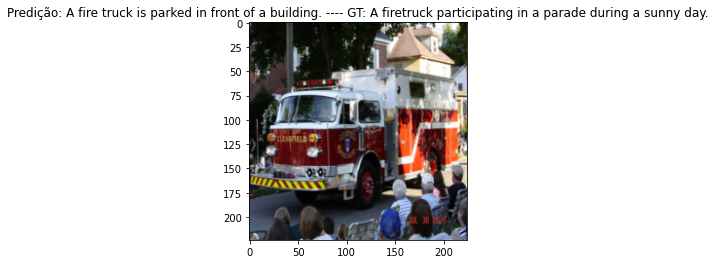

Época: 14/49 Train Loss: 2.142134 / Train BLEU: 10.338177178386141 Valid BLEU: 25.45666106306288


  0%|          | 0/784 [00:00<?, ?it/s]

2.129243538037044


  0%|          | 0/35 [00:00<?, ?it/s]

['A little girl holding a cat in her hands.', 'A parking meter sitting on the side of the road.', 'A blue car parked on the grass near a tree.', 'A cat is sitting on a toilet in a bathroom.', 'A man riding a motorcycle with a dog on the back of it.', 'A small airplane is on the runway.', 'A large jetliner sitting on top of an airport tarmac.', 'A car is parked on the side of the street.', 'A small plane flying through the air with a sky background.', 'A couple of birds sitting on a branch of a tree.', 'A bird sitting on a tree branch in a forest.', 'A cat sitting on a blue and white striped blanket.', 'A red fire truck parked next to a tree.', 'A dog laying on a bed with a blanket.', 'A cat is sitting on a chair next to a stuffed animal.', 'A cat sitting on a ledge next to a potted plant.', 'A cat is sitting in a suitcase on a bed.', 'A cat is sitting on a red chair.', 'A white truck with a white and black hood is parked on the side of the road.', 'A cow standing next to a cow in a fie

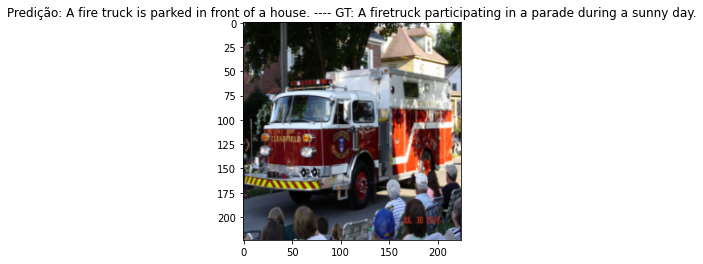

Época: 15/49 Train Loss: 2.129244 / Train BLEU: 10.46616789643333 Valid BLEU: 24.98122675684247


  0%|          | 0/784 [00:00<?, ?it/s]

2.1162469099009678


  0%|          | 0/35 [00:00<?, ?it/s]

['A woman holding a dog in her arms. him. him. him.', 'A horse drawn carriage is parked on the side of the road.', 'An old blue truck parked on the grass.', 'A cat is drinking water from a toilet.', 'A man riding a motorcycle down a street.', 'A small airplane sitting on top of a runway.', 'A plane parked at an airport with a person in the background.', 'A man walking down a street next to a car.', 'A red and white airplane flying in the sky.', 'A bird sitting on a branch in a tree.', 'A bear is sitting on a tree branch.', 'A cat sitting on top of a suitcase.', 'A red fire truck sitting on top of a river.', 'A dog sleeping on a couch with a cat on it. him. him. him. him.', 'A cat laying on a rug next to a stuffed animal.', 'A cat sitting on a stone wall next to a plant.', 'A cat laying in a suitcase on a bed.', 'A cat sitting on a chair in front of a mirror.', 'A truck with a trailer and a trailer on the back.', 'A horse standing in a field with a cow in the background.', 'A cat sittin

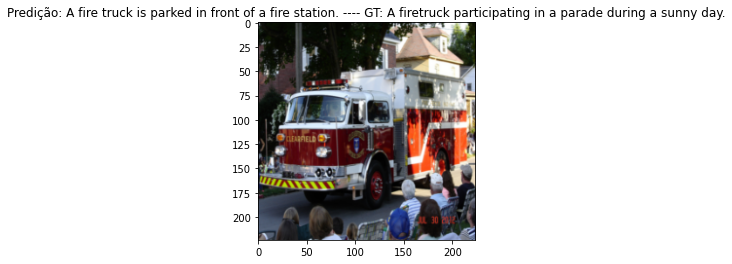

Época: 16/49 Train Loss: 2.116247 / Train BLEU: 10.66754043229596 Valid BLEU: 23.038875487741457


  0%|          | 0/784 [00:00<?, ?it/s]

2.1045896962356596


  0%|          | 0/35 [00:00<?, ?it/s]

['A little girl holding a cat in her hands.', 'A man riding a horse drawn carriage down a street.', 'A blue and white truck parked in a field.', 'A cat is drinking water from a toilet.', 'A man sitting on a red motorcycle in front of a house.', 'A small airplane is sitting on the runway.', 'A plane is parked on the tarmac at an airport.', 'A car is parked on the side of the street.', 'A red and white airplane flying in the sky.', 'A bird perched on a branch of a tree.', 'A bird perched on top of a tree branch.', 'A cat sitting on top of a blue suitcase.', 'A red boat is parked on the grass.', 'A cat is sleeping on a chair in a room.', 'A cat is sitting on a chair with a stuffed animal.', 'A cat is sitting on a wooden bench.', 'A cat laying in a suitcase on top of a bed.', 'A cat sitting on a chair in a living room.', 'A white and blue bus is parked on the side of the street.', 'A cow standing on top of a grass covered field.', 'A cat sitting on a couch next to a remote control.', 'A gi

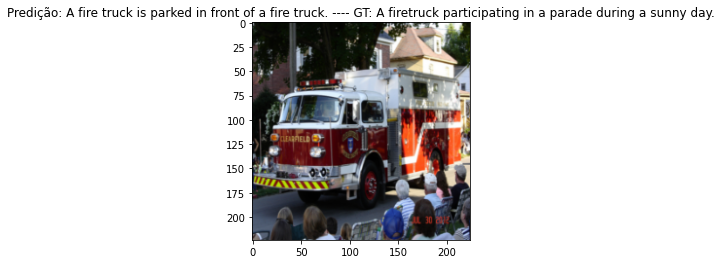

Época: 17/49 Train Loss: 2.104590 / Train BLEU: 10.530287978035727 Valid BLEU: 24.96951594962285


  0%|          | 0/784 [00:00<?, ?it/s]

2.0933743946068413


  0%|          | 0/35 [00:00<?, ?it/s]

['A woman holding a cat in her arms.', 'A man is walking down the street with a dog.', 'A blue and blue car parked in a grassy field.', 'A cat is sleeping on a toilet seat.', 'A man riding a motorcycle with a dog on the back.', 'A small airplane sitting on top of a runway.', 'A plane is parked at the airport with a person in the background.', 'A car is parked on the side of the road.', 'A red and white airplane flying in the sky.', 'A bird is sitting on a branch of a tree.', 'A bird sitting on a branch of a tree.', 'A cat sitting on top of a suitcase.', 'A red boat sitting on top of a river next to a river.', 'A dog laying on a bed with a blanket.', 'A cat laying on a bed with a pair of shoes.', 'A cat laying on a brick wall next to a plant.', 'A cat laying in a suitcase on a bed.', 'A cat sitting on a couch with a pillow.', 'A white truck is parked on the side of the road.', 'A dog and a dog are walking on a dirt road.', 'A cat sitting on a couch with a remote.', 'A group of giraffes 

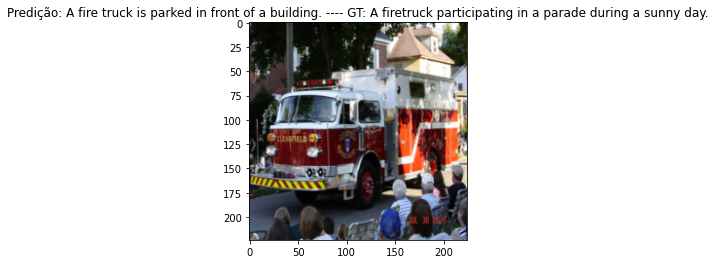

Época: 18/49 Train Loss: 2.093374 / Train BLEU: 10.875769406928205 Valid BLEU: 24.482356184487617


  0%|          | 0/784 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# Treinamento

model = EncoderDecoder(pretrained_model = (config_wandb["encoder_pretrained_model"], config_wandb["decoder_pretrained_model"]), 
                       eos_token_id=tokenizer.eos_token_id, 
                       pad_token_id=tokenizer.pad_token_id)

model = model.to(device)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=config_wandb["batch_size"], shuffle=True, collate_fn = collate_custom, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=config_wandb["batch_size"], collate_fn = collate_custom, drop_last=True)

# Optmizer
optimizer = torch.optim.Adam(model.parameters(), lr=config_wandb["learning_rate"])

# referencia: https://towardsdatascience.com/machine-translation-evaluation-with-sacrebleu-and-bertscore-d7fdb0c47eb3
bleu = BLEU()

# Initializing Lists
train_losses = []
val_losses = []
val_bleu_epoch = []
train_bleu_epoch = []


# Starting wandb
if run_id is not None:
    print(f"run_id: {run_id}")
    run = wandb.init(project="Image_Captioning", name=f"experiment_{run}", config=config_wandb, resume=run_id, id=run_id, settings=wandb.Settings(start_method="thread"), reinit=True, dir=os.getenv("WANDB_DIR", config_wandb["path_save_checkpoints"]))

else:
    epoch_init = 0
    run = wandb.init(project="Image_Captioning", name=f"experiment_{run}", config=config_wandb, resume=True, settings=wandb.Settings(start_method="thread"), reinit=True, dir=os.getenv("WANDB_DIR", config_wandb["path_save_checkpoints"]))

# 3. Log gradients and model parameters - pode ter dado erro, cuidado! 
#wandb.watch(model)

if wandb.run.resumed:
    print("Wandb --resumed")
    wandb.restore(config_wandb["path_save_checkpoints"]+config_wandb["checkpoint_folder_name"])
    epoch_init = wandb.run.step
    print(epoch_init)
    checkpoint = torch.load(config_wandb["path_save_checkpoints"]+config_wandb["checkpoint_folder_name"])
    print(checkpoint['loss'])
    print(checkpoint['epoch'])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_init = checkpoint['epoch']+1
    loss = checkpoint['loss']

for epoch in range(epoch_init, config_wandb["epochs"]):
    bleu_list = []
    for batch, (train_inputs, train_targets, train_all_targets) in enumerate(tqdm(train_loader)):
        model.train()
        model.zero_grad()

        train_inputs = train_inputs.to(device)
        train_targets = train_targets.to(device)

        # para o calculo da loss deve aplicar a máscara no start of sequence também? 
        mylabels = train_targets.clone()
        mylabels[mylabels==tokenizer.pad_token_id] = -100

        train_output = model(images = train_inputs, targets=mylabels)
        logits = train_output.logits
        loss = train_output.loss
        
        train_preds = torch.argmax(logits, dim=-1)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        preds_sentences = tokenizer.batch_decode(train_preds,  skip_special_tokens=True) #returns a list
        bleu_result = bleu.corpus_score(preds_sentences, list(zip(*train_all_targets)))
        bleu_list.append(bleu_result.score)

        wandb.log({"train/batch": batch,
                   "train/batch/loss":loss.item(), 
                   "train/batch/bleu_score":bleu_result.score, 
                   "train/batch/bleu_score_p1":bleu_result.precisions[0],
                   "train/batch/bleu_score_p4":bleu_result.precisions[3]})
        
    train_loss = sum(train_losses)/len(train_losses)
    print(train_loss)
    train_bleu = sum(bleu_list)/len(bleu_list)
    train_bleu_epoch.append(train_bleu)
    torch.save(model, config_wandb["path_save_model"])
    

    with torch.no_grad():
        bleu_list = []
        for val_batch, (val_inputs, val_targets, val_all_targets) in enumerate(tqdm(val_loader)):
            val_inputs = val_inputs.to(device)

            model.eval()
    
            decoded_ids = torch.full((val_inputs.shape[0], 1),
                            model.decoder_start_token_id,
                            dtype=torch.long).to(val_inputs.device)
            
            for step in range(32):
                output_val =  model(images =  val_inputs, decoder_ids= decoded_ids)
                
                #print(f"logits.shape: {output_val.logits.shape}")
                val_logits = output_val.logits
                next_token_logits = val_logits[:, -1, :]
                next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
                decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)
                #print(f"decoded_ids batch: {decoded_ids}")

                # Check if output is end of senquence for all batches
                if torch.eq(next_token_id[:, -1], model.eos_token_id).all():
                    break



            val_preds_sentences = tokenizer.batch_decode(decoded_ids,  skip_special_tokens=True)
            print(val_preds_sentences)
            bleu_result = bleu.corpus_score(val_preds_sentences, list(zip(*val_all_targets)))
            bleu_list.append(bleu_result.score)

            wandb.log({"val/batch": val_batch, 
                    "val/batch/loss":loss.item(),
                   #"val/batch/preds_sentences": val_preds_sentences, 
                   "val/batch/bleu_score":bleu_result.score, 
                   "val/batch/bleu_score_p1":bleu_result.precisions[0],
                   "val/batch/bleu_score_p4":bleu_result.precisions[3]})
            #my_table = wandb.Table(columns=["Image", "captions_generated"], data=[val_inputs,val_preds_sentences])
            #run.log({"val/table": my_table}, step=epoch)
        val_bleu = sum(bleu_list)/len(bleu_list)
        val_bleu_epoch.append(val_bleu)
            
    
    if epoch % config_wandb["eval_epochs"] == 0:
        plt.figure()
        plt.imshow(unorm(val_inputs[0].cpu()).permute(1,2,0))
        plt.title("Predição: "+str(val_preds_sentences[0] + " ---- GT: " +str(val_all_targets[0][0])))
        plt.show()
        plt.pause(0.05)

    wandb.log({"epoch": epoch, 
                "train/epoch/loss": train_loss,
                "train/epoch/bleu_score": train_bleu, 
                "val/epoch/bleu_score": val_bleu})

    torch.save({ # Save our checkpoint loc
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        }, config_wandb["path_save_checkpoints"]+config_wandb["checkpoint_folder_name"])
    wandb.save() # saves checkpoint to wandb
         
    print(f'Época: {epoch:d}/{config_wandb["epochs"] - 1:d} Train Loss: {train_loss:.6f} / Train BLEU: {train_bleu} Valid BLEU: {val_bleu}')

In [ ]:
wandb.finish()

# Avaliação

In [ ]:
model = torch.load(config_wandb["path_save_model"])
run_id = '1jp17q6g'

In [ ]:
run = wandb.init(project="Image_Captioning", name=f"experiment_{run}", config=config_wandb, resume=run_id, id=run_id, settings=wandb.Settings(start_method="thread"), reinit=True, dir=os.getenv("WANDB_DIR", config_wandb["path_save_checkpoints"]))

val_loader = DataLoader(val_dataset, batch_size=1, collate_fn = collate_custom)
columns = ["id", "image", "predicted", "captions (GT)", "BLEU", "BLEU-1", "BLEU-4"]
mytable = wandb.Table(columns=columns)

bleu = BLEU()

with torch.no_grad():
    for idx, (val_inputs, val_targets, val_all_targets) in enumerate(tqdm(val_loader)):
        model.eval()
        val_inputs = val_inputs.to(device)
        decoded_ids = torch.full((val_inputs.shape[0], 1),
                            model.decoder_start_token_id,
                            dtype=torch.long).to(val_inputs.device)
            
        for step in range(32):
            output_val =  model(images =  val_inputs, decoder_ids= decoded_ids)
                
            #print(f"logits.shape: {output_val.logits.shape}")
            val_logits = output_val.logits
            next_token_logits = val_logits[:, -1, :]
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
            decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)
            #print(f"decoded_ids batch: {decoded_ids}")

            # Check if output is end of senquence for all batches
            if torch.eq(next_token_id[:, -1], model.eos_token_id).all():
                break


        
        val_preds_sentences = tokenizer.batch_decode(decoded_ids,  skip_special_tokens=True)
        bleu_result = bleu.corpus_score(val_preds_sentences, val_all_targets)
        #unorm(val_inputs.squeeze().cpu()).permute(1,2,0)
        mytable.add_data(idx, wandb.Image(unorm(val_inputs.squeeze().cpu()).permute(1,2,0).numpy()), val_preds_sentences, val_all_targets[0], bleu_result.score, bleu_result.precisions[0], bleu_result.precisions[3])

       
wandb.log({f"Table_ViT_T5_experiment_{run}": mytable})


wandb: Currently logged in as: larissa_santesso. Use `wandb login --relogin` to force relogin


  0%|          | 0/1052 [00:00<?, ?it/s]

In [ ]:
wandb.finish()

# Backup

In [ ]:
columns=["predicted", "GT"]
test_table = wandb.Table(columns=columns)
test_table.add_data(val_preds_sentences, val_all_targets)   

# Log your Table to W&Bval_preds_sentences, val_all_targets
wandb.log({"predictions": my_table})

Error: ignored

In [ ]:
my_table = wandb.Table()

my_table.add_column("image", wandb.Image(list(val_inputs)))
my_table.add_column("predicted", val_preds_sentences)
my_table.add_column("GT", val_all_targets)

# Log your Table to W&Bval_preds_sentences, val_all_targets
wandb.log({"predictions": my_table})